### Predicting Board Game Scores

### Samurai Champloo

### Student Names

#### 1. Max Calehuff 

#### 2. Srikar Murali

#### 3. Xiao Rao


### 1) Ask:

#### Can we predict the score of the board game using the features of the game?

### 2) Acquire

#### The data comes from https://github.com/rfordatascience/tidytuesday/tree/master/data/2019/2019-03-12

#### The description is in the page below.

#### We will use following features

· max_players

· max_playtime

· min_age

· min_players

· min_playtime

· playing_time

· compilation

· expansion

· users_rated

· category

· mechanic

· cat_na

· mech_na

#### Some features are transformed in the data cleaning and processing sections.

### 3) Process

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn import neighbors
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#### Load Data

In [2]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2019/2019-03-12/board_games.csv")

In [3]:
X = data.copy()

#### Cleaning the Numeric Data


In [4]:
X = X[X.game_id != 30]  # remove erroneous rows
X[(X.max_players >= 30) | (X.max_players == 0)] = X['max_players'].mode()[0]
X[X.max_playtime == 0] = X['max_playtime'].mode()[0]
X[X.min_age > 21] = X['min_age'].mode()[0]
X[X.min_players == 0] = X['min_players'].mode()[0]
X[X.min_playtime == 0] = X['min_playtime'].mode()[0]
X[X.playing_time == 0] = X['playing_time'].mode()[0]

In [5]:
y = X["average_rating"]
X = X.drop(["average_rating"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Feature Engineering

#### Fix Columns

In [7]:
def drop_cols(df):
    """Drop columns which aren't being used."""
    df = df.drop(['game_id', 'description', 'image', 'name',
                  'thumbnail', 'artist', 'designer', 'family',
                  'publisher', 'year_published'], axis=1)
    return df

In [8]:
def binary_cols(df, col):
    "Convert columns to binary values."
    df[col].loc[~df[col].isnull()] = 1  # not nan
    df[col].loc[df[col].isnull()] = 0   # nan
    return df

In [9]:
X_train = drop_cols(X_train)
X_train = binary_cols(X_train, "compilation")
X_train = binary_cols(X_train, "expansion")

X_test = drop_cols(X_test)
X_test = binary_cols(X_test, "compilation")
X_test = binary_cols(X_test, "expansion")

#### Transform Categorical Variables

In [10]:
category_map = {"Economic": "Theme", "Card Game": "Card Game", "Abstract Strategy": "Strategy",
                "Ancient": "History", "Civilization": "History", "Exploration": "Exploration", "Fantasy": "Theme",
                "Negotiation": "Strategy", "Bluffing": "Strategy", "Collectible Components": "Collectible Components",
                "Miniatures": "Collectible Components", 'American West': 'History', 'Science Fiction': 'Theme',
                'Adventure': 'Theme', 'Fighting': 'Theme', 'Deduction': 'Strategy', 'Dice': 'Dice',
                'Aviation / Flight': 'Theme', 'Renaissance': 'History', 'City Building': 'Building',
                'Medieval': 'History', 'Trivia': 'Trivia', 'Political': 'Theme', 'Wargame': 'Wargame',
                'American Civil War': 'History', 'Age of Reason': 'History', 'Animals': 'Theme', 'Nautical': 'Theme',
                'Territory Building': 'Building', 'Prehistoric': 'History', 'Electronic': 'Electronic',
                'Action / Dexterity': 'Action / Dexterity', 'Educational': 'Educational', 'Racing': 'Theme', 'Print & Play': 'Print & Play',
                'Trains': 'Theme', 'Party Game': 'Party Game', 'Civil War': 'History', 'American Indian Wars': 'History',
                'Napoleonic': 'History', 'Humor': 'Theme', 'Movies / TV / Radio theme': 'Theme',
                'American Revolutionary War': 'History', 'Mafia': 'Theme', "Children's Game": "Children's Game",
                'Comic Book / Strip': 'Theme', 'Arabian': 'Theme', 'Novel-based': 'Theme', 'Pirates': 'Theme',
                'Transportation': 'Theme', 'Puzzle': 'Puzzle', 'Music': 'Music', 'Horror': 'Theme', 'Post-Napoleonic': 'History',
                'Sports': 'Theme', 'Farming': 'Theme', 'Murder/Mystery': 'Theme', 'Word Game': 'Word Game', 'Book': 'Theme',
                'Medical': 'Theme', 'Memory': 'Memory', 'Maze': 'Maze', 'Modern Warfare': 'History', 'Environmental': 'Theme',
                'Spies/Secret Agents': 'Theme', 'Math': 'Theme', 'Industry / Manufacturing': 'Building', 'Pike and Shot': 'Pike and Shot',
                'Space Exploration': 'Theme', 'Game System': 'Game System', 'Korean War': 'History', 'Real-time': 'Real-time',
                'Vietnam War': 'History', 'Video Game Theme': 'Theme', 'Mature / Adult': 'Theme', 'Travel': 'Theme',
                'Religious': 'History', 'Mythology': 'History', 'Expansion for Base-game': 'Theme',
                'Number': 'Theme', 'Zombies': 'Theme', 'World War II': 'History', 'World War I': 'History'
                }
mechanic_map = {'Area Control / Area Influence': 'Area Control', 'Trick-taking': 'Trick-taking',
                'Action Point Allowance System': 'Action System', 'Hand Management': 'Card Management', 'Dice Rolling': 'Dice Usage',
                'Area Enclosure': 'Area Control', 'Modular Board': 'Area Control', 'Card Drafting': 'Card Management',
                'Auction/Bidding': 'Economic System', 'Roll / Spin and Move': 'Dice Usage',
                'Action / Movement Programming': 'Action System', 'Tile Placement': 'Area Control', 'Area Movement': 'Area Control',
                'Commodity Speculation': 'Economic System', 'Co-operative Play': 'Co-operative Play', 'Hex-and-Counter': 'Hex-and-Counter',
                'Route/Network Building': 'Building System', 'Set Collection': 'Card Management', 'Grid Movement': 'Area Control',
                'Campaign / Battle Card Driven': 'Story Driven', 'Secret Unit Deployment': 'Unit Deployment',
                'Betting/Wagering': 'Economic System', 'Partnerships': 'Player Based', 'Rock-Paper-Scissors': 'Luck Based Decisions',
                'Point to Point Movement': 'Area Control', 'Crayon Rail System': 'Building', 'Voting': 'Player Based',
                'Paper-and-Pencil': 'Hand Writing', 'Line Drawing': 'Hand Writing',
                'Simultaneous Action Selection': 'Action System', 'Pick-up and Deliver': 'Pick-up and Deliver',
                'Press Your Luck': 'Luck Based Decisions', 'Player Elimination': 'Player Based',
                'Memory': 'Memory', 'Area-Impulse': 'Area Control', 'Stock Holding': 'Economic System',
                'Variable Player Powers': 'Player Based', 'Take That': 'Player Based', 'Pattern Building': 'Pattern Based', 'Trading': 'Economic System', 'Pattern Recognition': 'Pattern Based',
                'Chit-Pull System': 'Building', 'Simulation': 'Story Driven', 'Acting': 'Acting', 'Role Playing': 'Story Driven', 'Deck / Pool Building': 'Building',
                'Storytelling': 'Story Driven', 'Singing': 'Singing', 'Variable Phase Order': 'Unit Deployment', 'Time Track': 'Player Based', 'Worker Placement': 'Unit Deployment'
                }

In [11]:
def fix_categorical_cols(data):
    """Transform and map categorical columns."""
    cats = data['category'].str.split(',', expand=True)
    mechanic = data['mechanic'].str.split(',', expand=True)
    data = pd.concat([data, cats[0]], axis=1)
    data = pd.concat([data, mechanic[0]], axis=1)
    data = data.drop(['category', 'mechanic'], axis=1)
    data.columns = ['max_players', 'max_playtime', 'min_age', 'min_players', 'min_playtime',
                    'playing_time', 'compilation', 'expansion', 'users_rated',
                    'category', 'mechanic']
    # Map categorical column values to reduce the number of unique values
    data.category = data.category.map(category_map)
    data.mechanic = data.mechanic.map(mechanic_map)
    return data

In [12]:
X_train = fix_categorical_cols(X_train)

# Add columns to training data that contains 0 or 1 depending on if the value in the category/mechanic column is nan
X_train.loc[X_train.category.isna(), 'cat_na'] = 1
X_train.loc[~X_train.category.isna(), 'cat_na'] = 0
X_train.loc[X_train.mechanic.isna(), 'mech_na'] = 1
X_train.loc[~X_train.mechanic.isna(), 'mech_na'] = 0


X_test = fix_categorical_cols(X_test)

# Add columns to testing data that contains 0 or 1 depending on if the value in the category/mechanic column is nan
X_test.loc[X_test.category.isna(), 'cat_na'] = 1
X_test.loc[~X_test.category.isna(), 'cat_na'] = 0
X_test.loc[X_test.mechanic.isna(), 'mech_na'] = 1
X_test.loc[~X_test.mechanic.isna(), 'mech_na'] = 0

#### Standardize Numeric Columns

In [13]:
def standardize_cols(data, cols):
    """Standardize numeric columns."""
    features = data[cols]
    ct = ColumnTransformer([
        ('scl', StandardScaler(), cols)
    ], remainder='passthrough')  # pass through columns that are not specified
    scaled_features = ct.fit_transform(features)
    data[cols] = scaled_features
    return data

In [14]:
X_train = standardize_cols(X_train, ['max_players', 'max_playtime', 'min_age',
                                     'min_players', 'min_playtime', 'playing_time', 'users_rated'])

X_test = standardize_cols(X_test, ['max_players', 'max_playtime', 'min_age',
                                   'min_players', 'min_playtime', 'playing_time', 'users_rated'])

#### Factorize Categorical Columns

In [15]:
# Factorize categorical columns mechanic and category in training data
X_train["category"] = pd.factorize(X_train["category"])[0]
X_train["mechanic"] = pd.factorize(X_train["mechanic"])[0]

# Factorize categorical columns mechanic and category in testing data
X_test["category"] = pd.factorize(X_test["category"])[0]
X_test["mechanic"] = pd.factorize(X_test["mechanic"])[0]

# Drop categorical columns category and mechanic for Random Forest regressor
# Random Forest regressor seems to perform better without categorical columns

X_train_rf = X_train.drop(['category', 'mechanic'], axis=1)

X_test_rf = X_test.drop(['category', 'mechanic'], axis=1)

In [16]:
def is_rf(name, train=True):
    """Return the correct X data set depending on the model."""
    if train:
        if name == "RandomForestRegressor":
            return X_train_rf
        return X_train
    if name == "RandomForestRegressor":
        return X_test_rf
    return X_test

### 4) Model Building and Evaluation

#### Pipeline

In [17]:
def make_pipeline(models, X_train, y_train):
    """Create and fit pipeline for various models."""
    pipes = []
    for model in models:
        X_tr = is_rf(name=type(model).__name__, train=True)
        pipe = Pipeline([('scl', StandardScaler()),
                         ('pca', PCA(n_components=2)),
                         ('model', model)])
        pipe.fit(X_tr, y_train)
        pipes.append(pipe)
    return pipes

In [18]:
models = make_pipeline([LinearRegression(), Ridge(alpha=100),
                        Lasso(alpha=0.2),
                        RandomForestRegressor(
                            max_depth=2, random_state=0, n_estimators=100),
                        ],
                       X_train, y_train)
d = {'knn__n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]}
knn_pipe = Pipeline([('scl', MinMaxScaler(feature_range=(0, 1))),
                     ('knn', neighbors.KNeighborsRegressor())])
knn_pipe.fit(X_train, y_train)
models.append(knn_pipe)

#### Cross Validation Score

In [19]:
kfold = KFold(n_splits=5, random_state=42)
for pipe in models:
    name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]
    print(name)
    X_tr = is_rf(name=name, train=True)
    results = cross_val_score(pipe,
                              X_tr,
                              y_train,
                              cv=kfold,
                              scoring='r2')
    print("Average Training R Squared Score: " +
          str(round(np.array(results).mean(), 4)))
    print("")

LinearRegression
Average Training R Squared Score: 0.2799

Ridge
Average Training R Squared Score: 0.2805

Lasso
Average Training R Squared Score: 0.2909

RandomForestRegressor
Average Training R Squared Score: 0.6879

KNeighborsRegressor
Average Training R Squared Score: 0.7547



#### Model Prediction

In [20]:
for pipe in models:
    name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]
    print(name)
    X_tr = is_rf(name=name, train=True)
    X_te = is_rf(name=name, train=False)
    y_pred = pipe.predict(X_tr)
    print("Median Absolute Training Error: " +
          str(round(median_absolute_error(y_train, y_pred), 4)))
    print("R Squared Score Training: " +
          str(round(r2_score(y_train, y_pred), 4)))
    y_pred_test = pipe.predict(X_te)
    print("Median Absolute Testing Error: " +
          str(round(median_absolute_error(y_train, y_pred), 4)))
    print("R Squared Score Testing: " +
          str(round(r2_score(y_train, y_pred), 4)))
    print("")

LinearRegression
Median Absolute Training Error: 0.6329
R Squared Score Training: 0.327
Median Absolute Testing Error: 0.6329
R Squared Score Testing: 0.327

Ridge
Median Absolute Training Error: 0.6321
R Squared Score Training: 0.327
Median Absolute Testing Error: 0.6321
R Squared Score Testing: 0.327

Lasso
Median Absolute Training Error: 0.6234
R Squared Score Training: 0.3155
Median Absolute Testing Error: 0.6234
R Squared Score Testing: 0.3155

RandomForestRegressor
Median Absolute Training Error: 0.5231
R Squared Score Training: 0.7056
Median Absolute Testing Error: 0.5231
R Squared Score Testing: 0.7056

KNeighborsRegressor
Median Absolute Training Error: 0.3473
R Squared Score Training: 0.8513
Median Absolute Testing Error: 0.3473
R Squared Score Testing: 0.8513



### Randomized Search CV

In [21]:
# track final r2 values and median absolute error values
r2_scores = []
mae_scores = []

#### K-Nearest Neighbors

In [22]:
d = {'knn__n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]}
knn_pipe = Pipeline([('scl', MinMaxScaler(feature_range=(0, 1))),
                     ('knn', neighbors.KNeighborsRegressor())])

model = RandomizedSearchCV(knn_pipe, d)
model.fit(X_train, y_train)

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('scl',
                                              MinMaxScaler(copy=True,
                                                           feature_range=(0,
                                                                          1))),
                                             ('knn',
                                              KNeighborsRegressor(algorithm='auto',
                                                                  leaf_size=30,
                                                                  metric='minkowski',
                                                                  metric_params=None,
                                                                  n_jobs=None,
                                                                  n_neighbors=5,
                                                         

In [23]:
y_pred = model.predict(X_test)
print("Median Absolute Test Error: " +
      str(round(median_absolute_error(y_test, y_pred), 4)))
print("R Squared Score: " + str(round(r2_score(y_test, y_pred), 4)))

Median Absolute Test Error: 0.471
R Squared Score: 0.6387


In [24]:
r2_scores.append(('K-Nearest Neighbors', round(r2_score(y_test, y_pred), 4)))
mae_scores.append(('K-Nearest Neighbors', round(
    median_absolute_error(y_test, y_pred), 4)))

#### Random Forest Regressor

In [25]:
d = {"pca__n_components": [1, 2, 4, 8], "rf__max_depth": [
    2, 4, 8, 10, 20], "rf__n_estimators": [10, 20, 50, 100, 500]}
tree_pipe = Pipeline([('scl', StandardScaler()),
                      ('pca', PCA()),
                      ('rf', RandomForestRegressor(max_depth=2, random_state=0, n_estimators=100))])
clf = RandomizedSearchCV(
    estimator=tree_pipe, param_distributions=d, n_jobs=-1, scoring="r2")

In [26]:
clf.fit(X_train_rf, y_train)

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('scl',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('pca',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=None,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('rf',
                                              RandomForestRegressor(bootstrap=True,
 

In [27]:
y_pred = clf.predict(X_test_rf)
print("Median Absolute Test Error: " +
      str(round(median_absolute_error(y_test, y_pred), 4)))
print("R Squared Score: " + str(round(r2_score(y_test, y_pred), 4)))

Median Absolute Test Error: 0.3965
R Squared Score: 0.712


In [28]:
r2_scores.append(('Random_Forest', round(r2_score(y_test, y_pred), 4)))
mae_scores.append(('Random_Forest', round(
    median_absolute_error(y_test, y_pred), 4)))

### Feature Importance Graph

#### credit to https://github.com/yihanw91/sf-crime/blob/master/crime.ipynb for graphing method

In [29]:
rf = clf.estimator.named_steps['rf']

In [30]:
rf.fit(X_train_rf, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [31]:
feature_importance = dict(zip(X_train.columns, rf.feature_importances_))
for name, importance in sorted(feature_importance.items(), key=lambda x: x[1],
                               reverse=True)[0:]:
    print(f"{name}: {importance:>.2%}")

min_players: 76.79%
users_rated: 6.95%
playing_time: 4.08%
max_players: 3.65%
min_playtime: 2.89%
max_playtime: 2.89%
min_age: 2.76%
compilation: 0.00%
expansion: 0.00%
category: 0.00%
mechanic: 0.00%


In [32]:
sorted_values = []
sorted_features = list(sorted(feature_importance.items(),
                              key=lambda x: x[1], reverse=True)[0:])
for n in sorted_features:
    sorted_values.append(n[1])

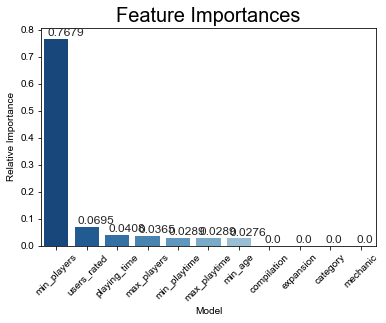

In [33]:
sns.barplot(list(range(len(sorted_features))),
            sorted_values, palette='Blues_r')
sns.set(rc={'figure.figsize': (15, 10)})
plt.text(-.3, sorted_values[0]+.01, round(sorted_values[0], 4))
plt.text(.7, sorted_values[1]+.01, round(sorted_values[1], 4))
plt.text(1.7, sorted_values[2]+.01, round(sorted_values[2], 4))
plt.text(2.7, sorted_values[3]+.01, round(sorted_values[3], 4))
plt.text(3.7, sorted_values[4]+.01, round(sorted_values[4], 4))
plt.text(4.7, sorted_values[5]+.01, round(sorted_values[5], 4))
plt.text(5.7, sorted_values[6]+.01, round(sorted_values[6], 4))
plt.text(6.85, sorted_values[7]+.01, round(sorted_values[7], 4))
plt.text(7.85, sorted_values[8]+.01, round(sorted_values[8], 4))
plt.text(8.85, sorted_values[9]+.01, round(sorted_values[9], 4))
plt.text(9.85, sorted_values[10]+.01, round(sorted_values[10], 4))
plt.xticks(ticks=range(len(sorted_features)), labels=[
           sorted_features[i][0] for i in range(len(sorted_features))], rotation=45)
plt.xlabel('Model')
plt.ylabel('Relative Importance')
plt.title('Feature Importances', size=20)
plt.show()

####  Linear Regression

In [34]:
parameters = {'pca__n_components': [1, 2, 4, 8], 'lr__fit_intercept': [
    True, False], 'lr__normalize': [True, False], 'lr__copy_X': [True, False]}
lin_reg_pipe = Pipeline([('scl', StandardScaler()),
                         ('pca', PCA()),
                         ('lr', LinearRegression())])
clf = RandomizedSearchCV(estimator=lin_reg_pipe,
                         param_distributions=parameters, n_jobs=-1, scoring='r2')

In [35]:
clf.fit(X_train, y_train)

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('scl',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('pca',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=None,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('lr',
                                              LinearRegression(copy_X=True,
         

In [36]:
y_pred = clf.predict(X_test)
print("Median Absolute Test Error: " +
      str(round(median_absolute_error(y_test, y_pred), 4)))
print("R Squared Score: " + str(round(r2_score(y_test, y_pred), 4)))

Median Absolute Test Error: 0.5749
R Squared Score: 0.2696


In [37]:
r2_scores.append(('Linear_Regression', round(r2_score(y_test, y_pred), 4)))
mae_scores.append(('Linear Regression', round(
    median_absolute_error(y_test, y_pred), 4)))

#### Ridge Regression

In [38]:
ridge_params = [10, 50, 100, 200, 250, 300]
parameters = {'pca__n_components': [1, 2, 4, 8], 'rg__fit_intercept': [True, False],
              'rg__normalize': [True, False], 'rg__copy_X': [True, False], 'rg__alpha': ridge_params}
ridge_reg_pipe = Pipeline([('scl', StandardScaler()),
                           ('pca', PCA()),
                           ('rg', Ridge())])
clf = RandomizedSearchCV(estimator=ridge_reg_pipe,
                         param_distributions=parameters, n_jobs=-1, scoring='r2')

In [39]:
clf.fit(X_train, y_train)

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('scl',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('pca',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=None,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('rg',
                                              Ridge(alpha=1.0, copy_X=True,
         

In [40]:
y_pred = clf.predict(X_test)
print("Median Absolute Test Error: " +
      str(round(median_absolute_error(y_test, y_pred), 4)))
print("R Squared Score: " + str(round(r2_score(y_test, y_pred), 4)))

Median Absolute Test Error: 0.5745
R Squared Score: 0.2705


In [41]:
r2_scores.append(('Ridge_Regression', round(r2_score(y_test, y_pred), 4)))
mae_scores.append(('Ridge Regression', round(
    median_absolute_error(y_test, y_pred), 4)))

#### Lasso

In [42]:
lasso_params = [0.02, 0.05, 0.1, 0.2, 0.4, 0.8]
parameters = {'pca__n_components': [1, 2, 4, 8], 'ls__fit_intercept': [True, False],
              'ls__normalize': [True, False], 'ls__copy_X': [True, False], 'ls__alpha': ridge_params}
lasso_reg_pipe = Pipeline([('scl', StandardScaler()),
                           ('pca', PCA()),
                           ('ls', Ridge())])
clf = RandomizedSearchCV(estimator=lasso_reg_pipe,
                         param_distributions=parameters, n_jobs=-1, scoring='r2')

In [43]:
clf.fit(X_train, y_train)

RandomizedSearchCV(cv='warn', error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('scl',
                                              StandardScaler(copy=True,
                                                             with_mean=True,
                                                             with_std=True)),
                                             ('pca',
                                              PCA(copy=True,
                                                  iterated_power='auto',
                                                  n_components=None,
                                                  random_state=None,
                                                  svd_solver='auto', tol=0.0,
                                                  whiten=False)),
                                             ('ls',
                                              Ridge(alpha=1.0, copy_X=True,
         

In [44]:
y_pred = clf.predict(X_test)
print("Median Absolute Test Error: " +
      str(round(median_absolute_error(y_test, y_pred), 4)))
print("R Squared Score: " + str(round(r2_score(y_test, y_pred), 4)))

Median Absolute Test Error: 0.572
R Squared Score: 0.2731


In [45]:
r2_scores.append(('Lasso_Regression', round(r2_score(y_test, y_pred), 4)))
mae_scores.append(('Lasso_Regression', round(
    median_absolute_error(y_test, y_pred), 4)))

### 5) Summary


Based on the $R^2$ and median absolute error values the Random Forest regressor seems to be the best model as it has the largest $R^2$ value and the smallest median absolute error value compared to the other models. Linear regression, Ridge regression and LASSO regression all performed similarly. 

The best $R^2$ obtained from the Random Forest regressor was 0.8212 and the best median absolute error value was 0.3996.


In [46]:
r2_scores.sort(key=lambda x: x[1], reverse=True)
mae_scores.sort(key=lambda x: x[1], reverse=True)
r2_scores = dict(r2_scores)
mae_scores = dict(mae_scores)

In [47]:
r2_scores

{'Random_Forest': 0.712,
 'K-Nearest Neighbors': 0.6387,
 'Lasso_Regression': 0.2731,
 'Ridge_Regression': 0.2705,
 'Linear_Regression': 0.2696}

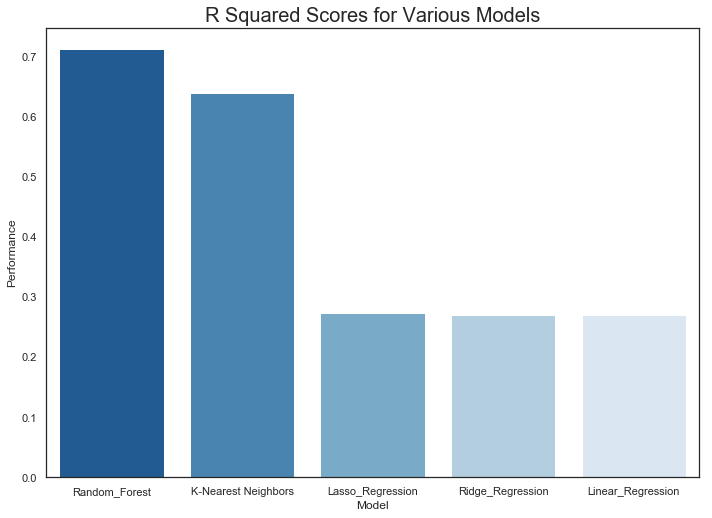

In [50]:
sns.barplot(x=list(range(len(r2_scores))), y=list(
    r2_scores.values()), palette='Blues_r')
sns.set_style(style='white')
sns.set(rc={'figure.figsize': (11.7, 8.27)})
plt.xticks(ticks=range(len(r2_scores)), labels=[
           mod for mod in r2_scores.keys()])
plt.xlabel('Model')
plt.ylabel('Performance')
plt.title('R Squared Scores for Various Models', size=20)
plt.show()

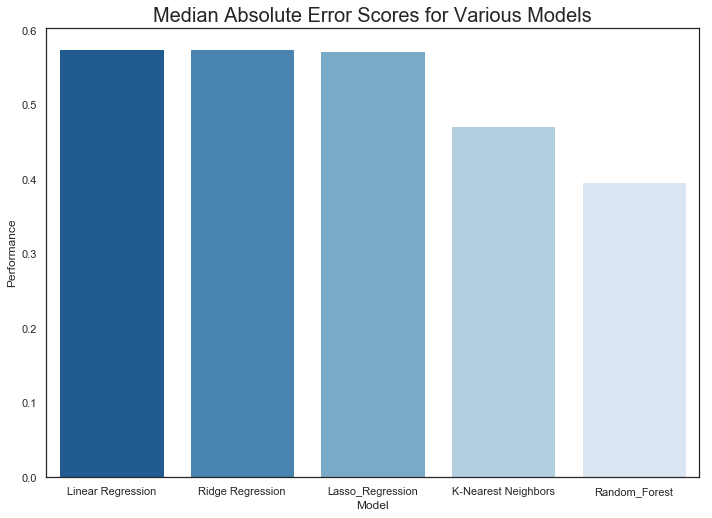

In [52]:
sns.barplot(x=list(range(len(mae_scores))), y=list(
    mae_scores.values()), palette='Blues_r')
sns.set(rc={'figure.figsize': (11.7, 8.27)})
sns.set_style(style='white')
plt.xticks(ticks=range(len(mae_scores)), labels=[
           mod for mod in mae_scores.keys()])
plt.xlabel('Model')
plt.ylabel('Performance')
plt.title('Median Absolute Error Scores for Various Models', size=20)
plt.show()